In [1]:
import numpy as np
import pandas as pd
import obspy
import math

import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl
import time

from matplotlib.colors import ListedColormap
plt.rcParams["figure.figsize"]= (15,15)


import sys
import os
ISCOLAB = 'google.colab' in sys.modules

import random
import json
import pprint
from obspy import Stream, Trace, UTCDateTime
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

base_dir = 'F:\Thesis_ssd\MasterThesis3.0'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Modeling.ResultFitter import ResultFitter
from Classes.Modeling.NarrowSearch import NarrowSearch
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
import json

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#%matplotlib notebook

In [6]:
### Data conditions: ###
load_args = {
    'earth_explo_only' : False,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : False,
    'upsample' : False,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 1,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'load_everything' : False,
    'load_first_batch' : True
}

loadData = LoadData(**load_args)
handler = DataHandler(loadData)

full_ds = loadData.full_ds[:,0:2]

In [7]:
full_ds

array([[ 'F:\\Thesis_ssd\\data_tord_may2020\\explosions\\2007-11-16T23.25.06.356000Z.h5',
        'explosion'],
       [ 'F:\\Thesis_ssd\\data_tord_may2020\\noise\\2019-05-11T02_32_23.000000Z.h5',
        'noise'],
       [ 'F:\\Thesis_ssd\\data_tord_may2020\\noise\\1998-11-22T03_32_57.000000Z.h5',
        'noise'],
       ..., 
       [ 'F:\\Thesis_ssd\\data_tord_may2020\\noise\\2006-08-06T08_47_35.000000Z.h5',
        'noise'],
       [ 'F:\\Thesis_ssd\\data_tord_may2020\\noise\\2009-07-04T11_54_19.000000Z.h5',
        'noise'],
       [ 'F:\\Thesis_ssd\\data_tord_may2020\\noise\\2004-04-02T07_18_39.000000Z.h5',
        'noise']], dtype=object)

In [28]:
def get_all_earthquakes(ds):
    return ds[ds[:,1] == "earthquake"]

def get_all_explosions(ds):
    return ds[ds[:,1] == "explosion"]

def get_magnitudes(ds):
    path_label_mag = []
    for path, label in ds:
        mag = handler.path_to_trace(path)[1].get('magnitudes')[0]['mag']
        path_label_mag.append([path, label, mag])
    return np.array(path_label_mag)

def get_mag_sqrtdist_ratios(ds):
    path_label_mdratio = []
    for path, label in ds:
        mdr = handler.path_to_trace(path)[1].get('magnitude_sqrtdist_ratio')
        path_label_mdratio.append([path, label, mdr])
    return path_label_mdratio

def round_feature(path_label_feature, decimals):
    path_label_feature_rounded = path_label_feature
    for idx, plf in enumerate(path_label_feature_rounded):
        path_label_feature_rounded[idx][2] = (int(np.round(float(plf[2]), decimals=decimals)*10**decimals))/(10**decimals)
    return np.array(path_label_feature_rounded)

def get_feature_counts_rounded(path_label_feature, decimals):
    path_label_feature_rounded = round_feature(path_label_feature, decimals)
    
    max_feature = math.ceil(max(np.array(path_label_feature_rounded[:,2], dtype=np.float64)))
    min_feature = math.floor(min(np.array(path_label_feature_rounded[:,2], dtype=np.float64)))
    
    intervals = [i/10**(decimals) for i in range(min_feature, max_feature*10**(decimals) +1)]
    interval_count = []
    
    for interval in intervals:
        current_count = 0
        for path, label, feature in path_label_feature_rounded:
            if float(feature) == interval:
                current_count += 1
        interval_count.append([interval, current_count])
        
    return np.array(interval_count)

def plot_mdr_distribution(ds, decimals, use_log_10 = False):
    path_label_mdr = get_mag_sqrtdist_ratios(ds)
    rounded_mdr = get_feature_counts_rounded(path_label_mdr, decimals)
    rounded_mdr = remove_empty_ends(rounded_mdr)
    mdr = rounded_mdr[:,0]
    counts = rounded_mdr[:,1]
    if use_log_10:
        counts = np.log10(counts, out=np.zeros_like(counts), where=(counts!=0))
    plt.bar(mdr, counts, align='center', alpha = 0.8, width=(1/(10**decimals)))
    plt.xlabel("MSDR")
    ylabel = "Frequency"
    if use_log_10:
        ylabel = "Log frequency"
    plt.ylabel(ylabel)
    dec = "decimals"
    if decimals == 1:
        dec = "decimal"
    plt.title(f"Magnitude squareroot distance ratio (MSDR) rounded to {decimals} {dec}")
    plt.show()
    return

def plot_mag_distribution(ds, decimals, use_log_10 = False):
    path_label_mag = get_magnitudes(ds)
    rounded_mags = get_feature_counts_rounded(path_label_mag, decimals)
    rounded_mags = remove_empty_ends(rounded_mags)
    mags = rounded_mags[:,0]
    counts = rounded_mags[:,1]
    if use_log_10:
        counts = np.log10(counts, out=np.zeros_like(counts), where=(counts!=0))
    plt.bar(mags, counts, align='center', alpha = 1.0, width=(1/(10**decimals)))
    ylabel = "Frequency"
    if use_log_10:
        ylabel = "Log frequency"
    plt.xlabel("Magnitude")
    plt.ylabel(ylabel)
    dec = "decimals"
    if decimals == 1:
        dec = "decimal"
    plt.title(f"Frequency of earthquakes of rounded magnitude to {decimals} {dec}")
    plt.show()
    return

def plot_mag_distribution_2(ds, decimals):
    path_label_mag = get_magnitudes(ds)
    label = path_label_mag[0][1]
    rounded_mags = get_feature_counts_rounded(path_label_mag, decimals)
    rounded_mags = remove_empty_ends(rounded_mags)
    mags = rounded_mags[:,0]
    counts_pure = rounded_mags[:,1]
    counts_log = np.log10(counts_pure, out=np.zeros_like(counts_pure), where=(counts_pure!=0))
    fig, (ax1, ax2) = plt.subplots(2)
    dec = "decimals"
    if decimals == 1:
        dec = "decimal"
    fig.suptitle(f"Frequency of {label}s of rounded magnitude to {decimals} {dec}")
    ax1.bar(mags, counts_pure, align='center', alpha = 1.0, width=(1/(10**decimals)))
    ax1.set_xlabel("Magnitude")
    ax1.set_ylabel("Frequency")
    ax2.bar(mags, counts_log, align='center', alpha = 1.0, width=(1/(10**decimals)))
    ax2.set_xlabel("Magnitude")
    ax2.set_ylabel("Log frequency")
    fig.show()

def plot_mdr_distribution_2(ds, decimals):
    path_label_mdr = get_mag_sqrtdist_ratios(ds)
    label = path_label_mdr[0][1]
    rounded_mdr = get_feature_counts_rounded(path_label_mdr, decimals)
    rounded_mdr = remove_empty_ends(rounded_mdr)
    mdr = rounded_mdr[:,0]
    counts_pure = rounded_mdr[:,1]
    counts_log = np.log10(counts_pure, out=np.zeros_like(counts_pure), where=(counts_pure!=0))
    fig, (ax1, ax2) = plt.subplots(2)
    dec = "decimals"
    if decimals == 1:
        dec = "decimal"
    fig.suptitle(f"Frequency of Magnitude Squareroot Distance Ratio of {label}s rounded to {decimals} {dec}")
    ax1.bar(mdr, counts_pure, align='center', alpha = 0.8, width=(1/(10**decimals)))
    ax1.set_xlabel("Magnitude Squareroot Distance Ratio")
    ax1.set_ylabel("Frequency")
    ax2.bar(mdr, counts_log, align='center', alpha = 0.8, width=(1/(10**decimals)))
    ax2.set_xlabel("Magnitude Squareroot Distance Ratio")
    ax2.set_ylabel("Log frequency")
    fig.show()
    
def remove_empty_ends(rounded_feature):
    start_index = 0
    for i in range(len(rounded_feature)):
        if rounded_feature[i][1] != 0:
            break
        else:
            start_index = i
    end_index = 0
    for i in range(len(rounded_feature)):
        if rounded_feature[::-1][i][1] != 0:
            break
        else:
            index_to_remove = i
    rounded_feature = rounded_feature[start_index:len(rounded_feature) - end_index]
    return rounded_feature
        


***Questions:***
 - Need better data (shorter and more succinct, and events centered)?
  - Are my samples really 1.5hrs long? Potential problems.. Short samples may lack P or S wave, while long
   samples may contain too much noise.
 - More complete info files. Cannot confirm which direction each channel refers to.
 - Viable to normalize EQ and EX events based on magnitude and distance?
  - Does the concept of apparent magnitude make sense in geology?
  - If so, should I oversample/undersample with respect to the Magnitude Squareroot Distance ratio? Or just magnitude.
   - I want to capture what an earthquake reads in the data, and have an evenly distributed sample of eqs wrt MSDR.
  - If not, should I produce an evenly distributed sample of eqs wrt to just Magnitude then?
 - Filters filters filters
  - Currently using highpass filter.
  - Should I spend time learning about Fourier transformations?
  - Simple explenation of Nyquist theorem?
  - Having a hard time to determine data Hz, due to questions about recording length.
 - GAN development for larger dataset?
 - Recommendations regarding how much noise to augment? Can you tell me something about Signal-To-Noise ratio? Important for my purposes?
 
 - Consider reducing scope to two classes due to significant limitations of data?


***Observations and facts:***

 - In the study: EQs in range M3.4 - M9.1. Most of my EQs are <M3. Makes classification more difficult.

 - P wave 60% faster than S wave

 - P wave more prominent in vertical seisometers: Z graph.
 - Poorly labeled dataset so hard to tell which one it is in my data. Assuming same format as the previous dataset the 0th channel should be the Z axis.
 - Very limited data samples limit depth of networks
 - Low magnitude EQs make discrimination very difficult.
 - Appears that the actual time of the earthquake event is unlabeled. This means that the earthquake can occur at any point during the 1.5 hours of recording. This can also mean that parts of the earthquake could be left ouf of the dataset. There exist at least one dp where the earthquake appears to occur at the very beginning of the sample.


***Further work related to data:***
 - Determine some optimal filter to apply to the dataset.
 - Oversample/Undersample to normalize
 - SMOTE (Survey on deep learning with class imbalance).
 - Attempt ensamble methods. That is let the good models all vote on class, and select the class that is most popular.


 - https://github.com/smousavi05/STEAD




## Distributions:

#### Magnitude distribution

In [12]:
earthquakes = get_all_earthquakes(full_ds)

<ipython-input-28-dc8c0e66ea32>:106: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


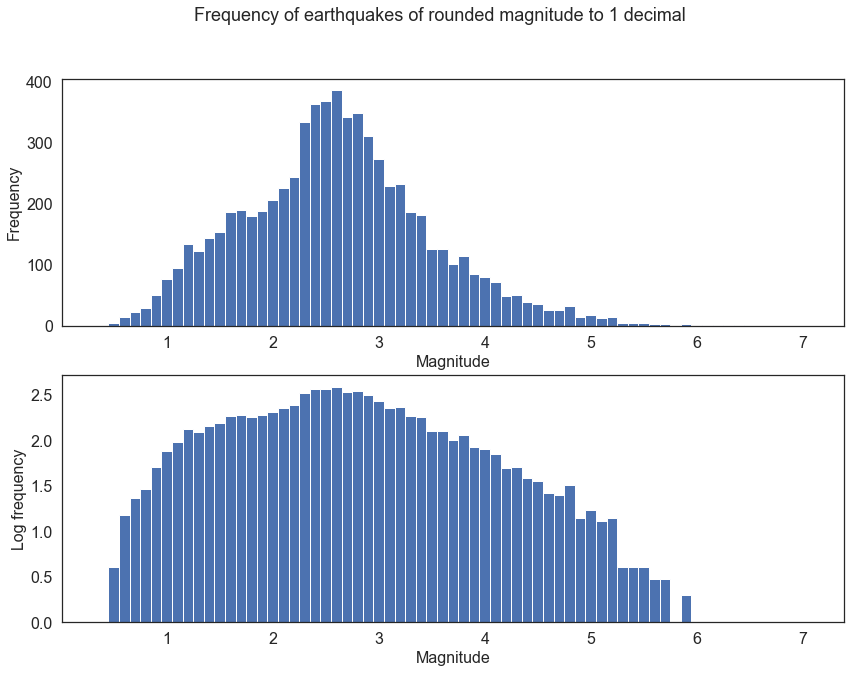

In [29]:
plot_mag_distribution_2(earthquakes, 1)

<ipython-input-20-8c1597c02b89>:127: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


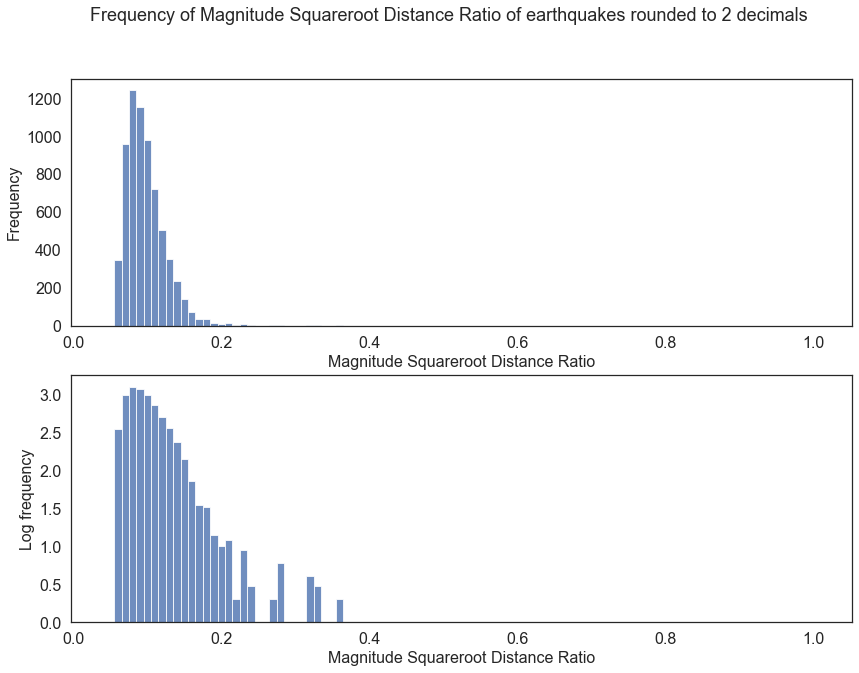

In [22]:
plot_mdr_distribution_2(earthquakes, 2)

<IPython.core.display.Javascript object>


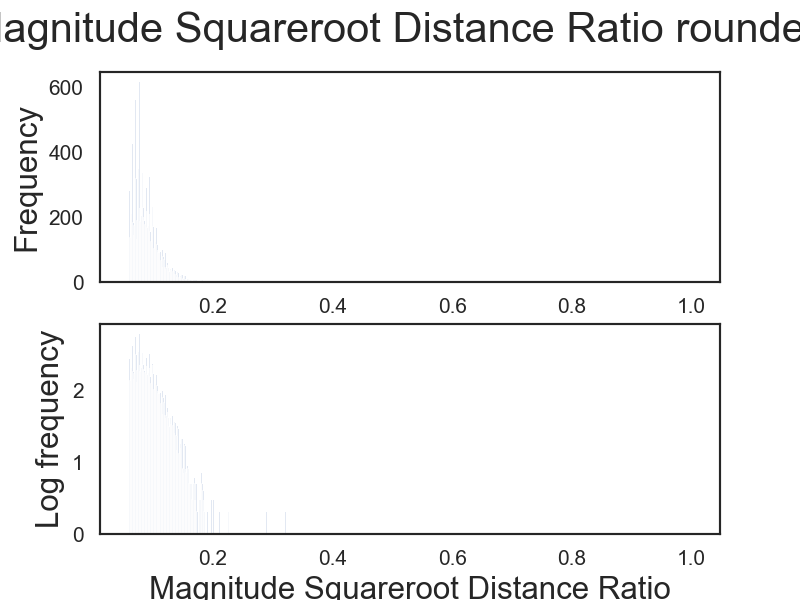

In [6]:
plot_mdr_distribution_2(full_ds, 3)

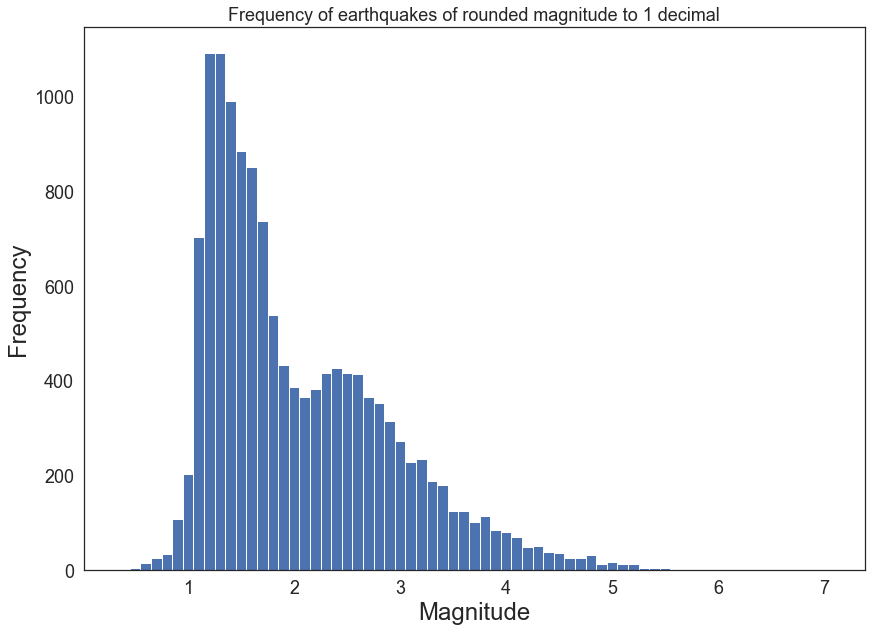

In [4]:
plot_mag_distribution(full_ds, 1, use_log_10 = False)

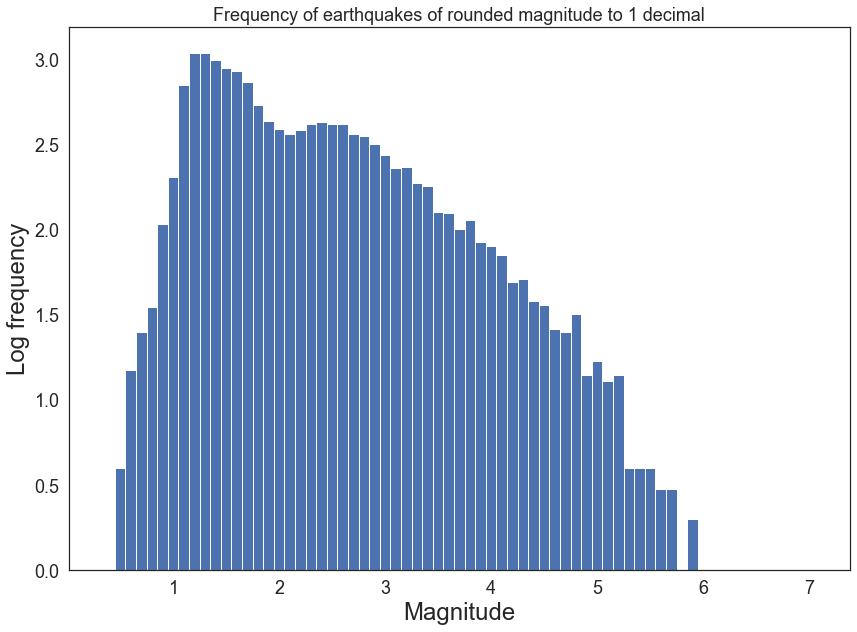

In [5]:
plot_mag_distribution(full_ds, 1, use_log_10 = True)

#### Magnitude Squareroot distance ratio distribution

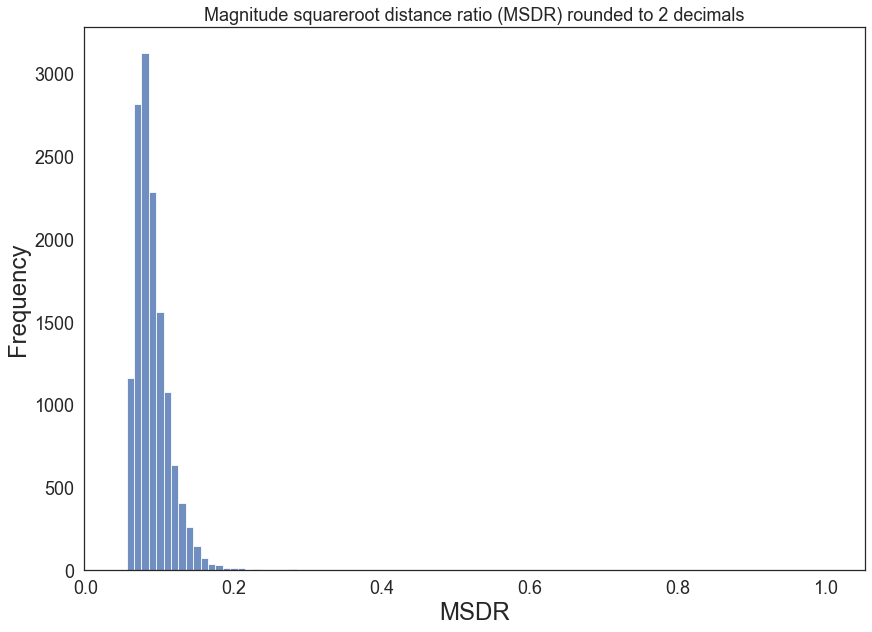

In [6]:
plot_mdr_distribution(full_ds, 2, use_log_10 = False)

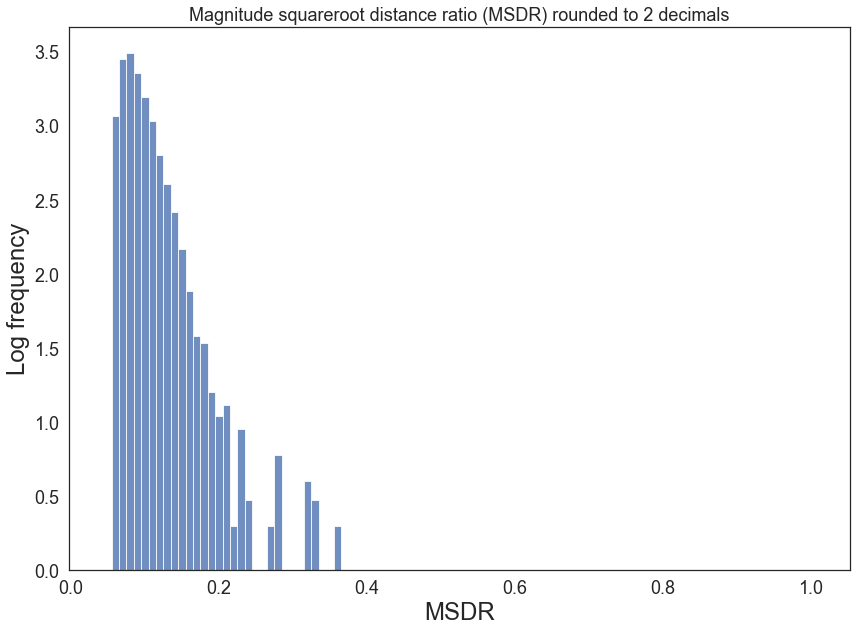

In [7]:
plot_mdr_distribution(full_ds, 2, use_log_10 = True)

In [8]:
import time

In [9]:
def n_simple_traces(train_ds, n):
    traces = np.empty((n, 3, 6001))
    start = time.time()
    for i in range(n):
        traces[i],_ = handler.path_to_trace(train_ds[i][0])
    end = time.time()
    total_time = end-start
    print(f"Exectuted {n} iterations in {total_time} seconds.")
    print(f"Each lookup took {total_time/n} seconds")

In [10]:
n_simple_traces(train_ds, 1000)

Exectuted 1000 iterations in 1.1923027038574219 seconds.
Each lookup took 0.001192302703857422 seconds


In [11]:

data = pd.HDFStore('F:\\Thesis_ssd\\LargeDataset\\merge.hdf5', 'r')

In [12]:
event_names = list(data.keys())

In [13]:
event_names

[]

In [14]:
len(full_ds)

20556